In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!pip install catboost

In [ ]:
!pip install vecstack

In [ ]:
!pip install chart_studio
import re # regex
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import HTML, display, clear_output
import time


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE, RFECV,VarianceThreshold,chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler,Normalizer 
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# Creating a Random Grid

from vecstack import stacking
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

import lightgbm as lgb
import xgboost as xgb
import catboost
from catboost import Pool, CatBoostClassifier,cv
from xgboost import XGBClassifier

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy
!pip install statsmodels
import statsmodels
import statsmodels.api as sm
# from statsmodels.formula.api import ols,Logit

from datetime import datetime
import os
print(os.listdir("/content/"))

['.config', 'test.csv', 'catboost_info', 'train.csv', 'adc.json', 'sample_submission.csv', '.ipynb_checkpoints', 'sample_data']


In [ ]:
%%time
train = pd.read_csv("/content/train.csv",parse_dates=['Date.of.Birth','DisbursalDate'])
test = pd.read_csv("/content/test.csv",parse_dates=['Date.of.Birth','DisbursalDate'])
sub = pd.read_csv("/content/sample_submission.csv")


CPU times: user 20.8 s, sys: 113 ms, total: 21 s
Wall time: 21.8 s


In [ ]:
train.shape, test.shape, sub.shape

((233154, 41), (112392, 40), (112392, 5))

In [ ]:
print('Loan default rate in first EMI is:', format(train.loan_default.sum()/train.shape[0]))

Loan default rate in first EMI is: 0.2170711203753742


In [ ]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,2018-03-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,Self employed,2018-01-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,Self employed,2018-10-26,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,1977-09-12,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   UniqueID                             233154 non-null  int64         
 1   disbursed_amount                     233154 non-null  int64         
 2   asset_cost                           233154 non-null  int64         
 3   ltv                                  233154 non-null  float64       
 4   branch_id                            233154 non-null  int64         
 5   supplier_id                          233154 non-null  int64         
 6   manufacturer_id                      233154 non-null  int64         
 7   Current_pincode_ID                   233154 non-null  int64         
 8   Date.of.Birth                        233154 non-null  datetime64[ns]
 9   Employment.Type                      225493 non-null  object        
 

In [ ]:
df = train.copy()

In [ ]:
df.loan_default.value_counts()

0    182543
1     50611
Name: loan_default, dtype: int64

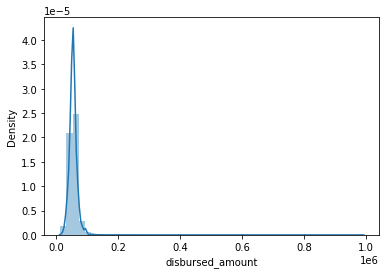

In [ ]:
sns.distplot(df.disbursed_amount)

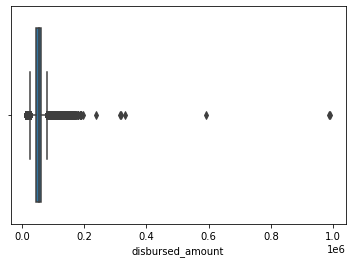

In [ ]:
sns.boxplot(df.disbursed_amount)

In [ ]:
## removed outliers
df=df[df['disbursed_amount']<200000].reset_index(drop=True)

In [ ]:
df['Employment.Type'].unique()

array(['Salaried', 'Self employed', nan], dtype=object)

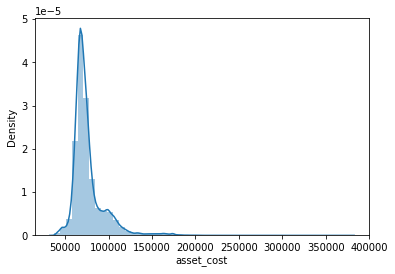

In [ ]:
sns.distplot(df.asset_cost)

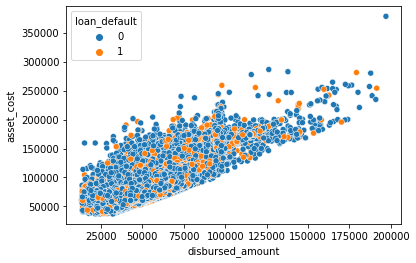

In [ ]:
sns.scatterplot(y=df.asset_cost, x=df.disbursed_amount,hue=df.loan_default)

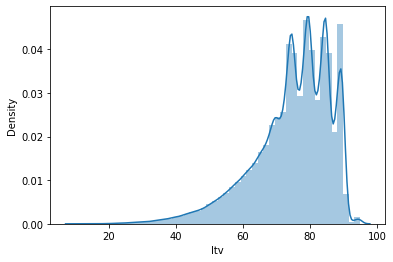

In [ ]:
sns.distplot(df.ltv)

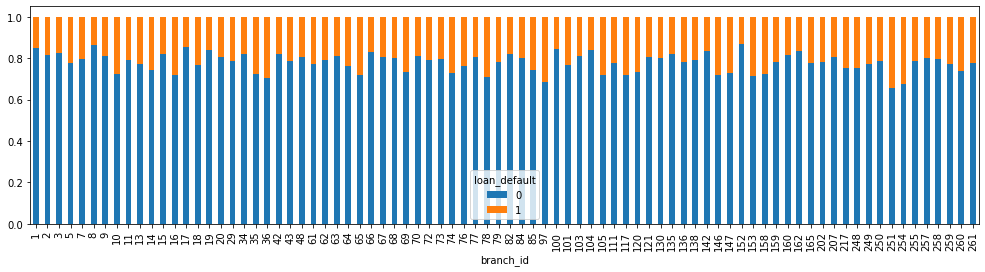

In [ ]:
ct=pd.crosstab(df.branch_id, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))

(402.9347894941585,
 1.2649508029241105e-89,
 1,
 array([[ 29148.19954792,   8081.80045208],
        [153387.80045208,  42529.19954792]]))

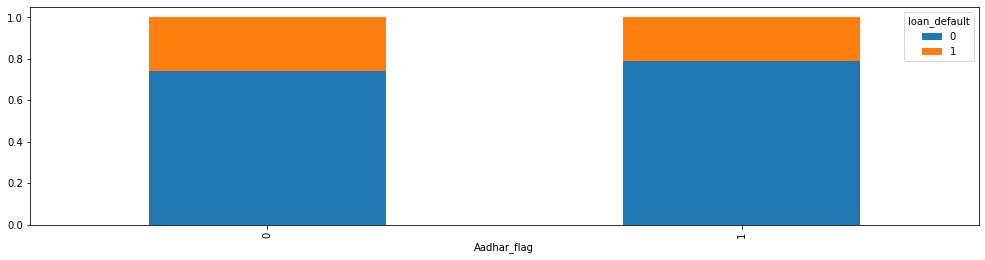

In [ ]:
ct=pd.crosstab(df.Aadhar_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

(1.00265262619473,
 0.31666950015785755,
 1,
 array([[168744.82258832,  46787.17741168],
        [ 13791.17741168,   3823.82258832]]))

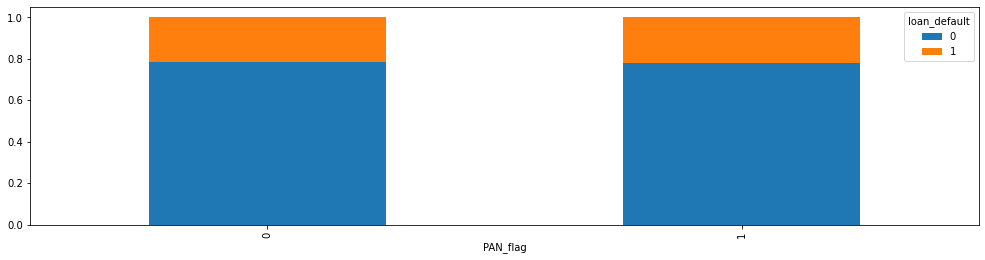

In [ ]:
ct=pd.crosstab(df.PAN_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

(445.7687139225628,
 6.011323264115359e-99,
 1,
 array([[156077.92168889,  43275.07831111],
        [ 26458.07831111,   7335.92168889]]))

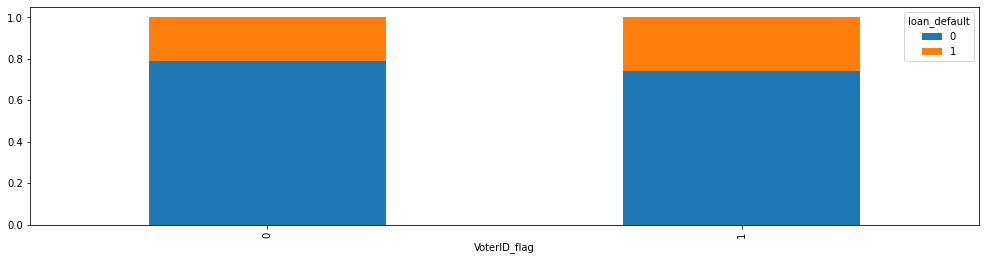

In [ ]:
ct=pd.crosstab(df.VoterID_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

(7.81450600180469,
 0.005182851325497511,
 1,
 array([[178293.34371877,  49434.65628123],
        [  4242.65628123,   1176.34371877]]))

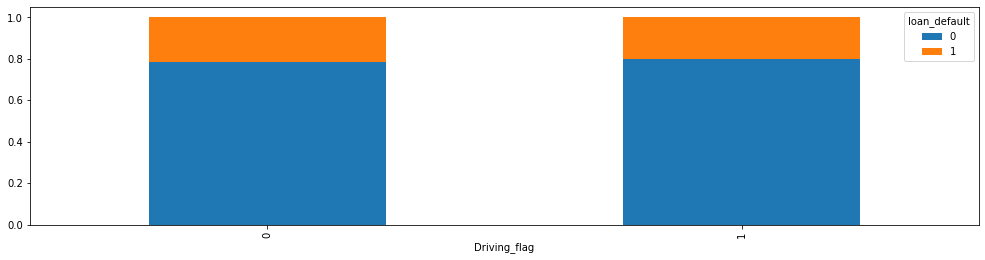

In [ ]:
ct=pd.crosstab(df.Driving_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

(13.080179391070391,
 0.00029843687220371747,
 1,
 array([[1.82147671e+05, 5.05033295e+04],
        [3.88329492e+02, 1.07670508e+02]]))

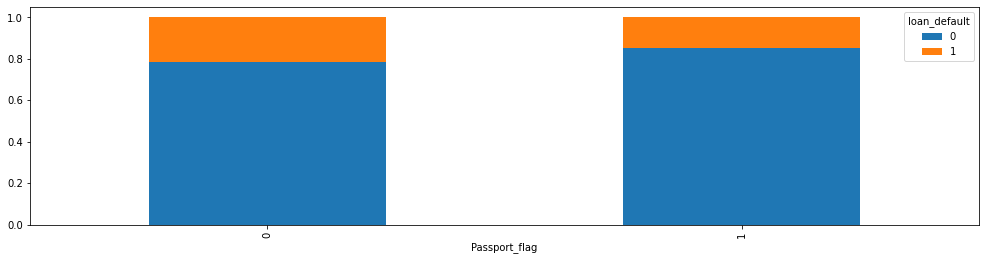

In [ ]:
ct=pd.crosstab(df.Passport_flag, df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

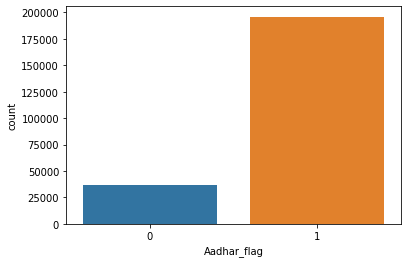

In [ ]:
sns.countplot(x=df.Aadhar_flag)

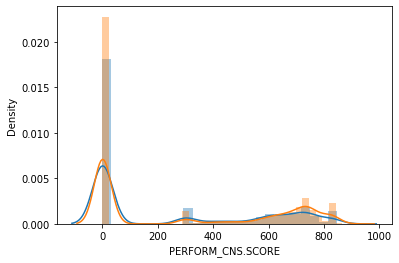

In [ ]:
sns.distplot(df[df['loan_default']==1]['PERFORM_CNS.SCORE'])
sns.distplot(df[df['loan_default']==0]['PERFORM_CNS.SCORE'])

In [ ]:
df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                116949
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9199
M-Very High Risk                                             8776
F-Low Risk                                                   8484
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3987
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3747
Not Scored: Not Enough Info available on the customer        3672
Not Scored

(2191.893143590023, 0.0, 19, array([[1.10579954e+04, 3.06600456e+03],
        [7.20210281e+03, 1.99689719e+03],
        [1.25619893e+04, 3.48301070e+03],
        [8.89243219e+03, 2.46556781e+03],
        [4.55739107e+03, 1.26360893e+03],
        [6.64231332e+03, 1.84168668e+03],
        [3.12151146e+03, 8.65488542e+02],
        [5.36693279e+03, 1.48806721e+03],
        [4.35069957e+03, 1.20630043e+03],
        [2.93361009e+03, 8.13389909e+02],
        [6.48024839e+03, 1.79675161e+03],
        [8.87833959e+02, 2.46166041e+02],
        [6.87092665e+03, 1.90507335e+03],
        [9.15619873e+04, 2.53870127e+04],
        [2.34876709e+00, 6.51232913e-01],
        [2.25794809e+03, 6.26051907e+02],
        [1.20100290e+03, 3.32997096e+02],
        [2.87489091e+03, 7.97109086e+02],
        [7.64132226e+02, 2.11867774e+02],
        [2.94770269e+03, 8.17297306e+02]]))

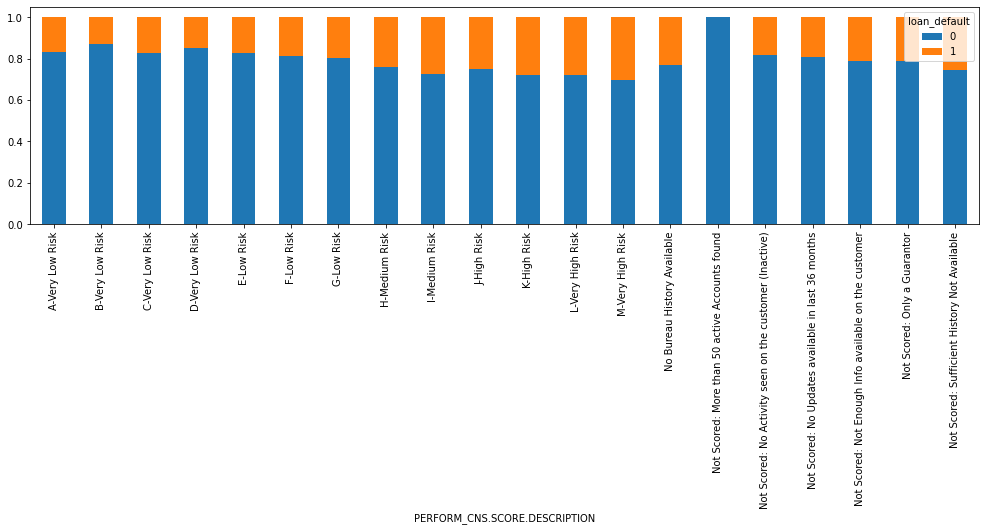

In [ ]:
ct=pd.crosstab(df['PERFORM_CNS.SCORE.DESCRIPTION'], df.loan_default)
ct.div(ct.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(17,4))
from scipy import stats
stats.chi2_contingency(ct)

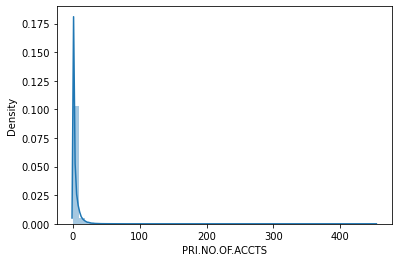

In [ ]:
sns.distplot(df['PRI.NO.OF.ACCTS'])

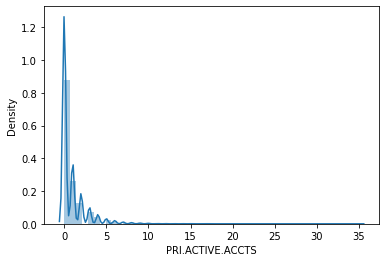

In [ ]:
sns.distplot(df[df['loan_default']==1]['PRI.ACTIVE.ACCTS'])
# sns.distplot(df[df['loan_default']==0]['PRI.ACTIVE.ACCTS'])

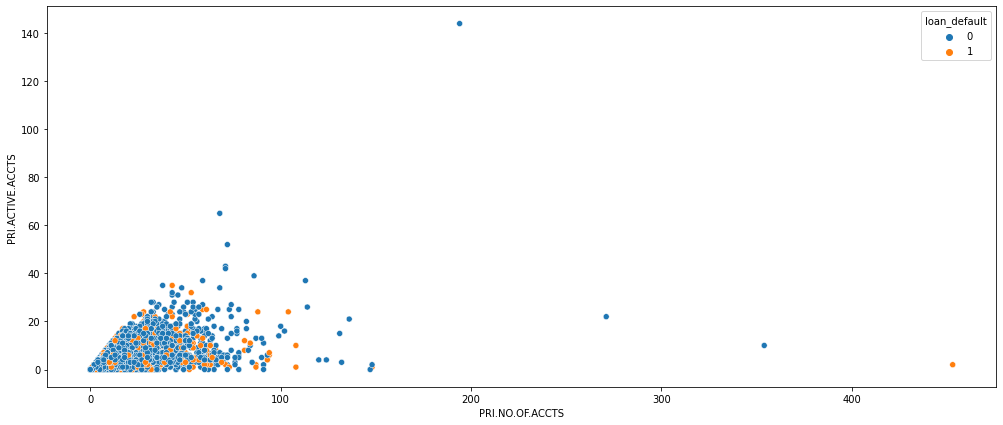

In [ ]:
plt.subplots(figsize=(17,7))
sns.scatterplot(x=df['PRI.NO.OF.ACCTS'] , y = df['PRI.ACTIVE.ACCTS'],hue=df.loan_default)

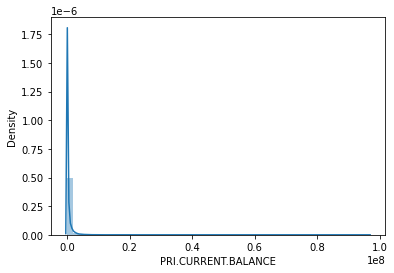

In [ ]:
sns.distplot(df[df['PRI.CURRENT.BALANCE']>0]['PRI.CURRENT.BALANCE'])

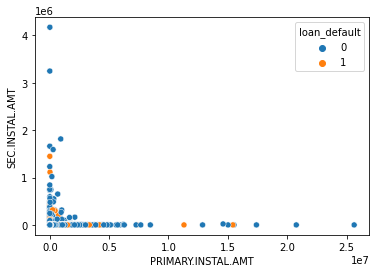

In [ ]:
sns.scatterplot(x=df['PRIMARY.INSTAL.AMT'],  y=df['SEC.INSTAL.AMT'],hue=df['loan_default'])

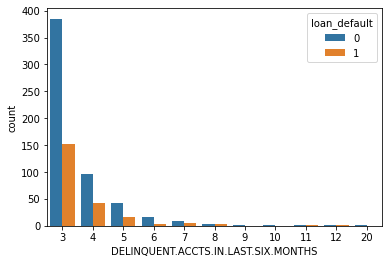

In [ ]:
sns.countplot(df[df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']>2]['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'],hue=df.loan_default)

In [ ]:
train.drop(index = [48879,85588,134575], axis=0, inplace= True)
train.reset_index(inplace= True)
train.drop('index', axis= 1, inplace = True)

In [ ]:
train=train[train['disbursed_amount']<200000].reset_index(drop=True)

In [ ]:
## There is missing value in only one column which is employment type we will impute this information
train['Employment.Type'].fillna('Others',inplace = True)
test['Employment.Type'].fillna('Others',inplace = True)

In [ ]:
train.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

In [ ]:
train.drop(columns= ['UniqueID','PAN_flag','MobileNo_Avl_Flag'], axis=1, inplace= True)
test.drop(columns= ['UniqueID','PAN_flag','MobileNo_Avl_Flag'], axis=1, inplace =True)

In [ ]:
train['BirthYear'] = train['Date.of.Birth'].dt.year
test['BirthYear'] = test['Date.of.Birth'].dt.year

train['DisbursalYear'] = train['DisbursalDate'].dt.year
test['DisbursalYear'] = test['DisbursalDate'].dt.year

train['Offset'] = 0
test['Offset'] = 0

train.loc[train.BirthYear > 2018, 'Offset'] = 100
test.loc[test.BirthYear > 2018, 'Offset'] = 100

train['BirthYear'] = train['BirthYear'] - train['Offset']
test['BirthYear'] = test['BirthYear'] - test['Offset']

train['ClientAge'] = train['DisbursalYear'] - train['BirthYear']
test['ClientAge'] = test['DisbursalYear'] - test['BirthYear']

train.drop(['Date.of.Birth','DisbursalYear','DisbursalDate','Offset'], axis=1, inplace= True)
test.drop(['Date.of.Birth','DisbursalYear','DisbursalDate','Offset'], axis=1, inplace= True)


In [ ]:
train['avg_acct_age_mnth'] = ((train['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + train['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
train['avg_credit_hist_mnth'] = ((train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

test['avg_acct_age_mnth'] = ((test['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + test['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
test['avg_credit_hist_mnth'] = ((test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

In [ ]:
train.drop(columns= ['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1, inplace= True)
test.drop(columns= ['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1, inplace =True)

In [ ]:
lb = LabelEncoder()
train['Employment.Type'] = lb.fit_transform(train['Employment.Type'])
test['Employment.Type'] = lb.transform(test['Employment.Type'])


train['PERFORM_CNS.SCORE.DESCRIPTION'] = lb.fit_transform(train['PERFORM_CNS.SCORE.DESCRIPTION'])
test['PERFORM_CNS.SCORE.DESCRIPTION'] = lb.transform(test['PERFORM_CNS.SCORE.DESCRIPTION'])

In [ ]:
models = [
    GradientBoostingClassifier(random_state=0, learning_rate=0.01, 
                  n_estimators=100, max_depth=5),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=5),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.01, 
                  n_estimators=100, max_depth=5)
]

In [ ]:
S_train, S_test = stacking(models, train.drop('loan_default',1), train.loan_default, test,regression=False, mode='oof_pred_bag', needs_proba=True, save_dir=None, metric='roc_auc', n_folds=4, stratified=True, shuffle=True, random_state=42)

In [ ]:
train['gbm'] = S_train[:,1]
train['rf'] = S_train[:,3]
train['xgb'] = S_train[:,5]

test['gbm'] = S_test[:,1]
test['rf'] = S_test[:,3]
test['xgb'] = S_test[:,5]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(train.drop('loan_default',1), train.loan_default, test_size = 0.2,
                                                random_state = 300)

In [ ]:
categ_column = ['branch_id','supplier_id', 'manufacturer_id','Current_pincode_ID','State_ID', 
                'Employee_code_ID','Aadhar_flag','VoterID_flag','Driving_flag', 'Passport_flag',
                'Employment.Type','PERFORM_CNS.SCORE.DESCRIPTION','avg_acct_age_mnth','avg_credit_hist_mnth']


In [ ]:
_train = Pool(x_train, label=y_train,cat_features= categ_column)
_valid = Pool(x_test, label=y_test,cat_features= categ_column)

In [ ]:
model = CatBoostClassifier(subsample=0.9, 
                           custom_loss='Logloss',
                           l2_leaf_reg = 10,
                           random_strength = 0,
                           max_depth=7,
                           eval_metric="AUC",
                           learning_rate=0.01,
                           iterations=10000,
                           bootstrap_type='Bernoulli',
                           task_type="GPU",
                           devices='0:1',
                           random_seed=42,
                           od_type="Iter",
                           border_count=128
                          )

In [ ]:
fit_model = model.fit(_train,verbose_eval=1000, early_stopping_rounds=1000,
                      eval_set=[_valid],use_best_model=True,plot=False)

0:	learn: 0.5569108	test: 0.5646370	best: 0.5646370 (0)	total: 77.7ms	remaining: 12m 57s
1000:	learn: 0.6694993	test: 0.6612405	best: 0.6612405 (1000)	total: 52s	remaining: 7m 47s
2000:	learn: 0.6812805	test: 0.6655933	best: 0.6655933 (2000)	total: 1m 46s	remaining: 7m 5s
3000:	learn: 0.6893852	test: 0.6672654	best: 0.6672779 (2977)	total: 2m 41s	remaining: 6m 15s
4000:	learn: 0.6961937	test: 0.6678374	best: 0.6678387 (3997)	total: 3m 35s	remaining: 5m 23s
5000:	learn: 0.7024133	test: 0.6679986	best: 0.6680114 (4992)	total: 4m 31s	remaining: 4m 31s
6000:	learn: 0.7081676	test: 0.6681101	best: 0.6681229 (5948)	total: 5m 27s	remaining: 3m 37s
7000:	learn: 0.7136819	test: 0.6680045	best: 0.6681656 (6384)	total: 6m 23s	remaining: 2m 44s
bestTest = 0.6681656241
bestIteration = 6384
Shrink model to first 6385 iterations.


In [ ]:
prediction = fit_model.predict_proba(test)[:,1]

In [ ]:
res=[]

for i in prediction:
  
  if (i>=0.025148 and i<=0.230857):
    res.append("Excellent")
  elif (i>0.230857 and i<=0.436566):
    res.append("Good")
  elif (i>0.436566 and i<=0.642275):
    res.append("Bad")
  else:
    res.append("Low")

s = pd.read_csv('/content/sample_submission.csv')
s["loan_default"] = prediction
s["class"]=res


import math
def scheme_1(x):
  return x//4

def scheme_2(x):
  return x//6

def scheme_3(x):
  return x//8


s["scheme_1"]=s["salary"].apply(scheme_1)
s["tenure_1"]=round(s["disbursed_amount"]/s["scheme_1"],1)
s["scheme_2"]=s["salary"].apply(scheme_2)
s["tenure_2"]=round(s["disbursed_amount"]/s["scheme_2"],1)
s["scheme_3"]=s["salary"].apply(scheme_3)
s["tenure_3"]=round(s["disbursed_amount"]/s["scheme_3"],1)
print(type(s['disbursed_amount']))




s.loc[(s['class']=="Excellent"), 'recommended scheme'] = 'Scheme 1'
s.loc[(s['class']=="Good"), 'recommended scheme'] = 'Scheme 2'
s.loc[(s['class']=="Bad"), 'recommended scheme'] = 'Scheme 3'

s.to_csv("result.csv", index=False)

s

<class 'pandas.core.series.Series'>


,UniqueID,loan_default,salary,disbursed_amount,asset_cost,class,scheme_1,tenure_1,scheme_2,tenure_2,scheme_3,tenure_3,recommended scheme
0,655269,0.270648,108887,53478,63558,Good,27221,2.0,18147,2.9,13610,3.9,Scheme 2
1,723482,0.355614,115012,55513,63163,Good,28753,1.9,19168,2.9,14376,3.9,Scheme 2
2,758529,0.307443,116353,65282,84320,Good,29088,2.2,19392,3.4,14544,4.5,Scheme 2
3,763449,0.221075,100172,46905,63896,Excellent,25043,1.9,16695,2.8,12521,3.7,Scheme 1
4,708663,0.259757,106315,51428,63896,Good,26578,1.9,17719,2.9,13289,3.9,Scheme 2
